# Model Inference
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hsimonfroy/benchmark-field-level/blob/main/examples/infer_model.ipynb)

Infer from a cosmological model via MCMC samplers.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.8' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload, Path

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

save_dir = Path("save_dir")
save_path = save_dir / "example"
save_dir.mkdir(parents=True, exist_ok=True)

[cuda(id=0)]
feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Experimental setup
### Instantiate model
We can see how the model is actually reparametrized.

###  Generate an observation and condition the model on it
We can see all the free parameters in the model, that we will subsequently sample.

# CONFIG
{'a_obs': None,
 'ap_param': True,
 'box_center': array([   0.,    0., 2000.]),
 'box_rotvec': array([0., 0., 0.]),
 'cell_length': 31.25,
 'curved_sky': False,
 'evolution': 'lpt',
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.02},
             'alpha_ap': {'group': 'bias',
                          'label': '{\\alpha}_{\\mathrm{ap}}',
                          'loc': 1.0,
                          'loc_fid': 1.0,
                          'scale': 5.0,
                          'scale_fid': 0.5},
             'alpha_iso': {'group': 'bias',
                           'label': '{\\alpha}_{\\mathrm{iso}}',
                           'loc': 1.0,
                           'loc

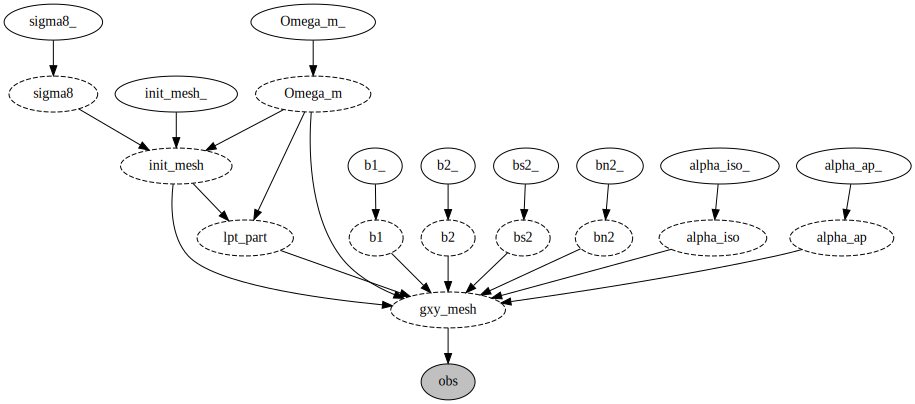

In [14]:
overwrite = True
truth0 = {'Omega_m': 0.3, 
    'sigma8': 0.8, 
    'b1': 1.,
    'b2':0., 
    'bs2':0., 
    'bn2': 0.,
    'alpha_iso': 1.,
    'alpha_ap': 1.,}

if not os.path.exists(save_dir / "truth.npz") or overwrite:
    cell_length = 1000. / 32
    model = FieldLevelModel(**default_config | {'mesh_shape': 3*(32,), 
                                #     'cell_length': 5., 
                                'cell_length': cell_length, 
                                'evolution': 'lpt',
                                'a_obs':None, # light-cone if None
                                'curved_sky':False, # curved vs. flat sky
                                'ap_param': True, # parametrized AP vs. auto AP
                                'box_center':(0.,0.,2000.), # in Mpc/h
                                'box_rotvec':(0.,0.,0.), # rotation vector in radians
                                'mask':0.6, # if float, mask fraction, if str or Path, path to mask file
                                } )

    print(model)
    truth = model.predict(samples=truth0, hide_base=False, hide_samp=False, frombase=True)
    model.save(save_dir / "model.yaml")    
    jnp.savez(save_dir / "truth.npz", **truth)

    model2 = FieldLevelModel(**model.asdict() | {'evolution': 'kaiser', 'curved_sky':False})
    print(model2)
    truth2 = model2.predict(samples=truth0, hide_base=False, hide_samp=False, frombase=True)
    model.save(save_dir / "model2.yaml")    
    jnp.savez(save_dir / "truth2.npz", **truth)
else:
    model = FieldLevelModel.load(save_dir / "model.yaml")
    print(model)
    truth = np.load(save_dir / "truth.npz")

    model2 = FieldLevelModel.load(save_dir / "model2.yaml")
    print(model2)
    truth2 = np.load(save_dir / "truth2.npz")


model.reset() # reset any previous blocking or conditioning
model.condition({'obs': truth['obs']})
model.render()
# model2.render()
model.block() # hide parameters that we do not need to trace and save
# model.render()

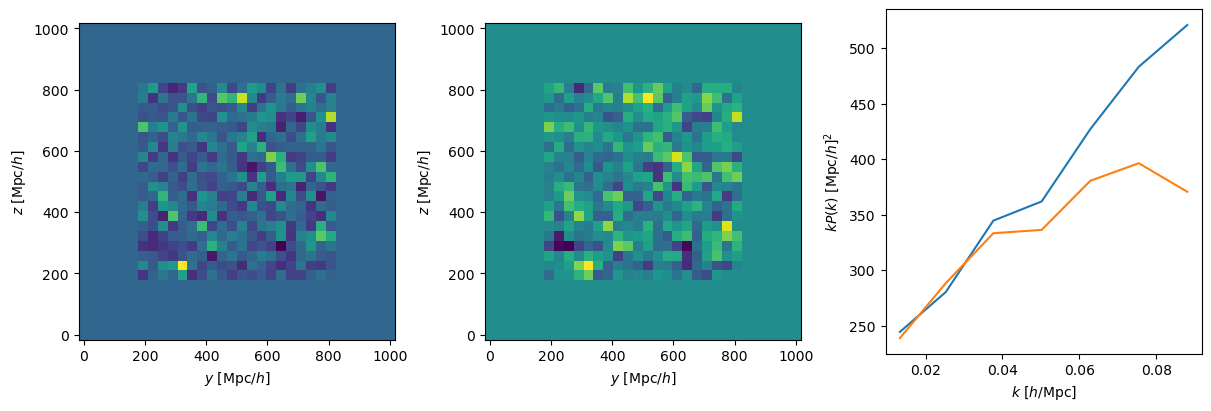

In [15]:
# Plot the observed galaxy density field
from montecosmo.plot import plot_mesh, plot_pow
plt.figure(figsize=(12, 4), layout='constrained')

obs_mesh = model.masked2mesh(truth['obs']-1)
obs_mesh2 = model2.masked2mesh(truth2['obs']-1)
axis = 0
plt.subplot(131)
plot_mesh(obs_mesh, model.box_shape, 0.1, axis=axis)

plt.subplot(132)
plot_mesh(obs_mesh2, model.box_shape, 0.1, axis=axis)

plt.subplot(133)
kpow = model.spectrum(obs_mesh)
kpow2 = model2.spectrum(obs_mesh2)
plot_pow(*kpow);
plot_pow(*kpow2);

## Perform the inference

### Warmup the field only

In [16]:
sampler = 'MCLMC'
n_samples, n_runs, n_chains = 32, 2, 8
tune_mass = True

obs_mesh = model.masked2mesh(truth['obs']-1)
init_params_ = jit(vmap(partial(model.kaiser_post, delta_obs=obs_mesh)))(jr.split(jr.key(45), n_chains))    
init_mesh_ = {k: init_params_[k] for k in ['init_mesh_']}

if not os.path.exists(save_path+"_init_last_state.p") or overwrite:
    model.reset()
    model.condition({'obs': truth['obs']} | model.loc_fid, frombase=True)
    model.block()

    from montecosmo.samplers import get_mclmc_warmup
    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**12, config=None, 
                                desired_energy_var=1e-6, diagonal_preconditioning=False)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), init_mesh_)
    pdump(state, save_path+"_init_last_state.p")
    pdump(config, save_path+"_init_conf.p")

else:
    state = pload(save_path+"_init_last_state.p")
    config = pload(save_path+"_init_conf.p")

params_ = init_params_ | state.position
model.reset()
model.condition({'obs': truth['obs']})
model.block()

Performed 4096.0 adaptation steps


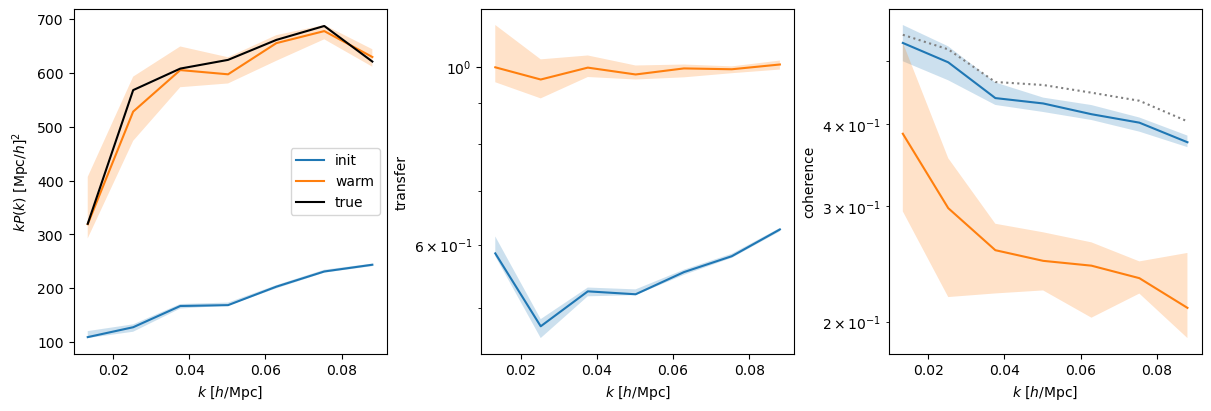

In [25]:
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
kptcs_init = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_)
kptcs_warm = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(params_)
kpow0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, obs_mesh)

prob = 0.95
plt.figure(figsize=(12, 4), layout='constrained')
tree_med = lambda y: tree.map(lambda x: jnp.median(x, 0), y)
plot_powtranscoh(*tree_med(kptcs_init), label='init')
plot_powtranscoh(*kptcs_init, fill=prob)
plot_powtranscoh(*tree_med(kptcs_warm), label='warm')
plot_powtranscoh(*kptcs_warm, fill=prob)
plt.subplot(131)
plot_pow(*kpow0, 'k', label='true')
plt.legend()
plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[3], ':', c='grey', label='obs')
# plt.savefig(f'init_glin_{task_id}.png')   

### Warmup all parameters and run

In [20]:
from tqdm import tqdm

if sampler == 'MCLMC':
    from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run
    from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState

    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**10, config=None, 
                                        desired_energy_var=1e-6, diagonal_preconditioning=tune_mass)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), params_)

    # eval_per_ess = 1e3
    # ss = jnp.median(config.step_size)
    # config = MCLMCAdaptationState(L=0.4 * eval_per_ess/2 * ss, 
    #                             step_size=ss, 
    #                             inverse_mass_matrix=jnp.median(config.inverse_mass_matrix, 0))
    # config = tree.map(lambda x: jnp.broadcast_to(x, (n_chains, *jnp.shape(x))), config)

    # pdump(state, save_path+"_last_state.p")
    # pdump(config, save_path+"_conf.p")
    
    # run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=16, progress_bar=False)))

    # key = jr.key(42)
    # for i_run in tqdm(range(1, n_runs + 1)):
    #     print(f"run {i_run}/{n_runs}")
    #     key, run_key = jr.split(key, 2)
    #     state, samples = run_fn(jr.split(run_key, n_chains), state, config)
        
    #     print("MSE per dim:", jnp.mean(samples['mse_per_dim'], 1), '\n')
    #     jnp.savez(save_path+f"_{i_run}.npz", **samples)
    #     pdump(state, save_path+"_last_state.p")


Performed 878.0 adaptation steps


In [27]:
state.position

{'Omega_m_': Array([-0.01435256,  0.01362028,  0.00467281, -0.03382198, -0.41119521,
        -0.00601164, -0.02621199,  0.03308307], dtype=float64),
 'alpha_ap_': Array([-1.08831829,  1.23339533, -1.23322939, 27.55334093,  0.8186223 ,
        -1.26537682, 19.80806959, -0.17177331], dtype=float64),
 'alpha_iso_': Array([ 1.91529738, -5.4011251 ,  0.68199189, 30.55813154, -0.56710096,
         1.1249796 , 25.45189949,  0.10878521], dtype=float64),
 'b1_': Array([ 0.00113989,  0.000127  , -0.01147669, -0.01564156, -0.02087099,
         0.00521606, -0.0080835 , -0.00607606], dtype=float64),
 'b2_': Array([ 0.02236347, -0.0024684 , -0.00246826,  0.00213193, -0.00129208,
         0.00250906, -0.009871  ,  0.00103981], dtype=float64),
 'bn2_': Array([-2.40696835e-02, -4.80871215e-03,  9.93173703e-03,  1.24228151e-03,
         7.14357167e-04, -8.10973103e-03,  2.39218929e-02,  2.07925598e-05],      dtype=float64),
 'bs2_': Array([-0.01878773, -0.01064648,  0.00089934,  0.00201449,  0.00166035,

In [24]:
import fitsio
picked_cols = fitsio.read(sourcecat, columns=sourcefield, rows=rows_to_pick)

NameError: name 'sourcecat' is not defined